In [2]:
import os
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.predict import get_prediction, get_sliced_prediction, predict
from sahi.scripts.coco_evaluation import evaluate_core
from IPython.display import Image

from solaris.vector.polygon import geojson_to_px_gdf

from sahi.scripts.coco_evaluation import evaluate

from PIL import Image

from copy import deepcopy

import pickle as pkl
import json
import numpy as np
import seaborn as sns

import os

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import geometry

/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-

## Notebook 2: Vegetation Index-Based Dieback Estimates

This notebook contains the relevant code for dieback estimation. Some of these cells take a while, so their results are written to the disk under this_repo/tmp/

Pre-calculated versions of these results - i.e. the results from the paper - are stored under almorox/pred_gdfs. You can find them in the zenodo repository (10.5281/zenodo.10646992), along with the rest of the data.

Cell 1: Contains a function returning a GeoDataFrame with inventory data and matched crown footprints for each tree that was covered by the field plots. The geodataframe will be saved under this_repo/tmp/pred_gdfs_area_i_gdf.csv for area i.\
Cell 2: Runs cell 1 for each of the 9 areas\
Cell 3: Concatenates the results and stores them under this_repo/tmp/concatenated_gdf.csv\
Cell 4: Plots the results. **This will load the pre-calculated version unless you change the directory.** 

In [2]:
def separate_points(input_list):
    """
    Separates COCO style predictions from SAHI
    [x1, y1, x2, y2, x3, y3, ...]

    into a list of points that can be turned into shapely geometries
    [[x1,y1],[x2,y2],[x3,y3], ...]
    """
    input_list = deepcopy(input_list)
    x_coordinates = input_list[0::2]
    y_coordinates = input_list[1::2]
    points = list(zip(x_coordinates, y_coordinates))
    return [list(point) for point in points]

def get_pred_gdf_for_area(area):
    """
    Returns a Geodataframe with the predictions for the specified area
    """
    detection_model = AutoDetectionModel.from_pretrained(  #Load model
    model_type='mmdet',
    model_path=f'almorox/models/{area}/epoch_12.pth',
    config_path=f'almorox/models/{area}/TESTAREA{area}_almo_mask_rcnn_r101_fpn_mstrain-poly_3x_coco.py',
    confidence_threshold=0.3,
    image_size=1024,
    device='cuda:0'
    )

    image_location = f'almorox/raw/images/area_{area}_clipped_RGB.tif'

    result = get_sliced_prediction(  #Get predicted polygons for the area
        image_location,
        detection_model,
        slice_height=1024,
        slice_width=1024,
        verbose=0,
        auto_slice_resolution=False
    )

    # COCO scoring =============================================================
    # coco_predictions = result.to_coco_predictions(image_id=1)  #n.b. might need to change image_id to 0

    # for i in range(len(coco_predictions)):
    #     coco_predictions[i]['category_id'] = 1

    # dataset_json_path = f'../data/almorox/raw/annotations/area_{area}_COCO.json'
    # result_json_path = 'drive/tmp.json'

    # with open(result_json_path, "w+") as f:
    #     json.dump(coco_predictions, f)

    # eval = evaluate(dataset_json_path=dataset_json_path,
    #             result_json_path=result_json_path,
    #             type="segm",
    #             return_dict=True)
    
    # with open(f'drive/area_{area}_coco_segm_eval.pkl', 'wb') as f:
    #     pkl.dump(eval, f)

    # os.remove(result_json_path)
    # os.remove("drive/eval.json")
    # ==========================================================================

    
    df = pd.read_csv('almorox/Tree_locations_Almorox_data.csv') #Load inventory data

    df = df[pd.to_numeric(df['X'], errors='coerce').notnull()] #Remove inventory points labelled "out"
    df = df[pd.to_numeric(df['Y'], errors='coerce').notnull()]

    plot_areas = pd.read_csv('almorox/plot_areas.csv') #Add area information to each row
    df['Area'] = df['Plot'].apply(lambda x: plot_areas[plot_areas['Plot'] == x]['Area'].values[0])

    df = df[df['Area'] == area] #Crop inventory to area 
    
    crs = "urn:ogc:def:crs:OGC:1.3:CRS84"
    gdf = gpd.GeoDataFrame( #Create geodataframe from inventory data
        df, crs=crs, geometry=gpd.points_from_xy(df.X, df.Y), )
    
    gdf = gdf.reset_index().drop(columns=['index']) #Reset indices
    gdf = gdf.set_crs(4326, allow_override=True) #Temporary workaround

    px_gdf = geojson_to_px_gdf(gdf, image_location, geom_col='geometry') #Convert inventory data to pixel coordinates
    px_gdf = px_gdf.drop_duplicates(subset=['geometry']) #Remove duplicate entries due to multistems(?)
    px_gdf = px_gdf.sort_values(by=["id"]).reset_index().drop(columns=['index'])

    # Load image
    im = Image.open(image_location) #Load image
    im_array = np.asarray(im)

    width, height = im.size 

    px_gdf_tmp = px_gdf[px_gdf.geometry.bounds['maxx'] < width] # Remove GT points outside image
    px_gdf_tmp = px_gdf_tmp[px_gdf_tmp.geometry.bounds['maxy'] < height] 

    if len(px_gdf_tmp) != len(px_gdf):
        print("WARNING: Removed GT points located outside image")

    px_gdf = px_gdf_tmp 

    px_gdf["assigned_multipolygon"] = None
    px_gdf["assigned_gcc"] = None

    assert px_gdf.duplicated(subset=['geometry']).any() == False

    predicted_multipolygons = []

    object_prediction_list = deepcopy(result.object_prediction_list)

    for predictions in object_prediction_list: #List of multiple predicted polygons
        separated_predictions = [separate_points(prediction) for prediction in predictions.mask.to_coco_segmentation()] #list of list of points, one entry for each polygon within bbox
        shapely_polygons = [geometry.Polygon(points) for points in separated_predictions] #list of shapely polygons, one entry for each polygon within bbox
        shapely_multipolygon = geometry.MultiPolygon(shapely_polygons) #single shapely multipolygon, describing all polygons within bbox

        predicted_multipolygons.append(shapely_multipolygon)

    # Calculate centroid for every predicted polygon
    multipolygon_centroids = [multipolygon.centroid for multipolygon in predicted_multipolygons]

    # Calculate distance from every point to every centroid
    trunk_to_predicted_centroid_distance = np.empty((len(px_gdf), len(multipolygon_centroids)))

    for i in range(len(px_gdf)):
        for j in range(len(multipolygon_centroids)):
            trunk_to_predicted_centroid_distance[i, j] = px_gdf.iloc[i].geometry.distance(multipolygon_centroids[j])

    gdf_indices = list(range(len(px_gdf)))

    # Until the the number of rows is zero:
    while trunk_to_predicted_centroid_distance.shape[0] > 0:
        min_indices = np.where(trunk_to_predicted_centroid_distance == np.min(trunk_to_predicted_centroid_distance))
        min_i, min_j = min_indices[0][0], min_indices[1][0]

        min_distance_multipolygon = predicted_multipolygons[min_j]

        # Calculate greenness for index j
        mask = object_prediction_list[min_j].mask.bool_mask
        new_im_array = np.empty(im_array.shape,dtype='uint8')

        for i in range(new_im_array.shape[2]):
            new_im_array[:,:,i] = im_array[:,:,i]*mask

        x, y, _ = np.nonzero(new_im_array)
        xl, xr = x.min(), x.max()
        yl, yr = y.min(), y.max()

        new_im_array = new_im_array[xl:xr+1, yl:yr+1, :]
        newIm = Image.fromarray(new_im_array, "RGB")

        total_nonzero = np.count_nonzero(mask) #Assume same number of nonzero in each channel
        total_red = np.sum(new_im_array[:,:,0])  
        total_green = np.sum(new_im_array[:,:,1])
        total_blue = np.sum(new_im_array[:,:,2])
        total_values = np.sum(new_im_array)

        assigned_gcc = total_green/total_values
        excess_green = (2*total_green - total_red - total_blue)/total_nonzero

        # print(assigned_gcc)

        # print(min_distance_multipolygon)
        # print(assigned_gcc)
        px_gdf.at[gdf_indices[min_i], 'assigned_multipolygon'] = min_distance_multipolygon
        px_gdf.at[gdf_indices[min_i], 'assigned_gcc'] = assigned_gcc
        px_gdf.at[gdf_indices[min_i], 'assigned_excess_green'] = excess_green

        # pop j from
        # matrix
        trunk_to_predicted_centroid_distance = np.delete(trunk_to_predicted_centroid_distance, min_j, axis=1)
        # multipolygons 
        predicted_multipolygons.pop(min_j)
        # object predction list 
        object_prediction_list.pop(min_j)
        # Could pop from centroids for completeness, not needed for calculations

        # pop i from 
        # matrix 
        trunk_to_predicted_centroid_distance = np.delete(trunk_to_predicted_centroid_distance, min_i, axis=0)
        # gdf index list
        gdf_indices.pop(min_i)

    pd_px_gdf = pd.DataFrame(px_gdf) 
    pd_px_gdf.to_csv(f"tmp/pred_gdfs_area_{area}_gdf.csv", index=False) #Save geodataframe to csv
    return px_gdf

In [3]:
pred_gdfs = []

for i in range(1,10): #(1,10)
    pred_gdfs.append(get_pred_gdf_for_area(i))

/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


load checkpoint from local path: almorox/models/1/epoch_12.pth


/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/home/matt/miniconda3/envs/mmdet/lib/python3.7/site-packages/sahi/postprocess/combine.py:289: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  matched_box_indices = order[(mask == False).nonzero().flatten()].flip(dims=(0,))


In [4]:
concatenated_gdf = gpd.GeoDataFrame(pd.concat(pred_gdfs, ignore_index=True), crs=pred_gdfs[0].crs)
concatenated_gdf['gt_multipolygon_distance'] = concatenated_gdf.apply(lambda row: row['geometry'].distance(row['assigned_multipolygon'].centroid)/np.sqrt(row['assigned_multipolygon'].area), axis=1)
pd_concatenated_gdf = pd.DataFrame(concatenated_gdf)
pd_concatenated_gdf.to_csv("tmp/concatenated_gdf_gt.csv", index=False)

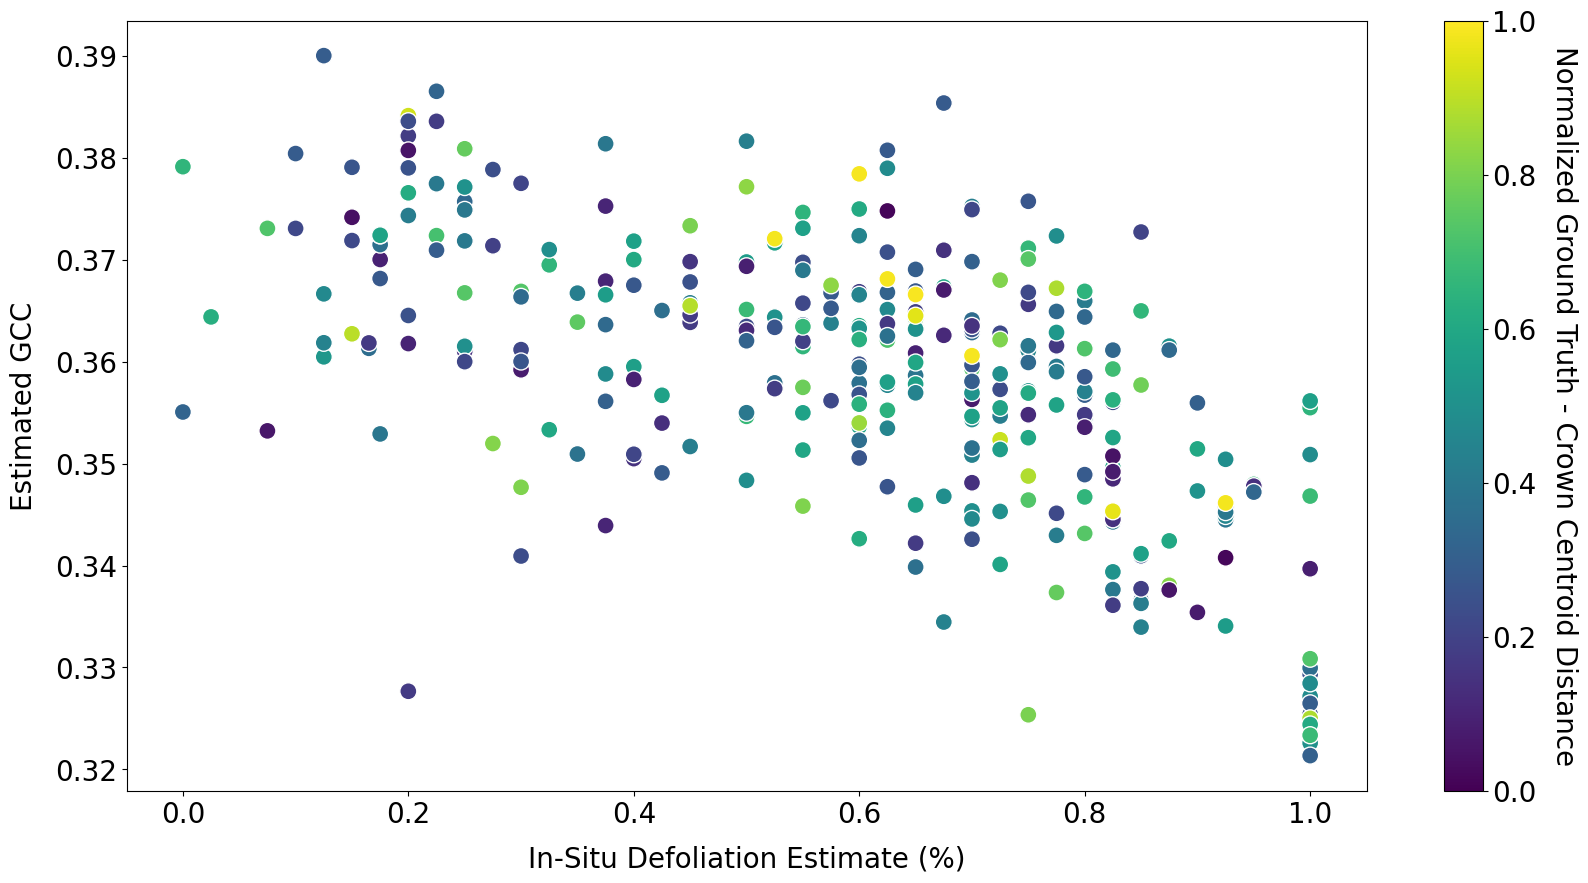

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig2, ax2 = plt.subplots(figsize=(20, 10))

concatenated_gdf = pd.read_csv("almorox/pred_gdfs/concatenated_gdf.csv")
concatenated_gdf = concatenated_gdf[concatenated_gdf['gt_multipolygon_distance'] <= 1]
concatenated_gdf['defoliacion'] = concatenated_gdf['defoliacion']/100
concatenated_gdf['defoliacion'] = concatenated_gdf['defoliacion'].astype('float64')

# Create the seaborn scatterplot
scatter = sns.scatterplot(data=concatenated_gdf, x='defoliacion', y='assigned_gcc', hue='gt_multipolygon_distance', hue_norm=(0, 1), palette="viridis", s=150, ax=ax2, legend=False)

# Set x and y labels
ax2.set_xlabel('In-Situ Defoliation Estimate (%)', fontsize=20, labelpad=12)  # Increase labelpad by 50% (default is 10)
ax2.set_ylabel('Estimated GCC', fontsize=20, labelpad=12)

# Increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=20)

# Add the colorbar
norm = plt.Normalize(vmin=0, vmax=1)
scalarmappable = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
scalarmappable.set_array([])
cbar = plt.colorbar(scalarmappable, ax=ax2)
cbar.set_label('Normalized Ground Truth - Crown Centroid Distance', rotation=270, labelpad=30, fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()
